In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, cv, Pool

In [2]:
train_df, test_df = pd.read_csv('train.csv'), pd.read_csv('test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin and Embarked columns has missing values. Need to filling them before applying model.

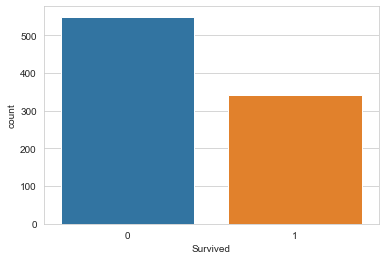

In [4]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=train_df);

Target is well-balanced in train.
Let's make Exploratory Data Analysis.

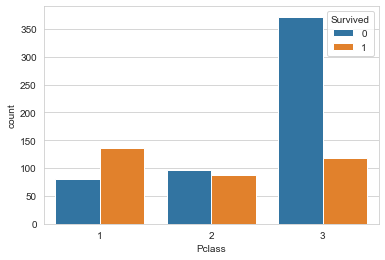

In [5]:
sns.countplot(x='Pclass', hue='Survived', data=train_df);

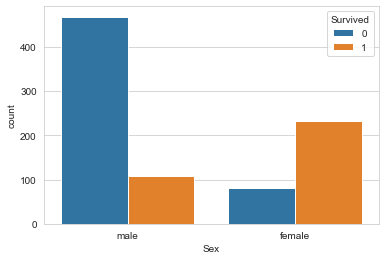

In [6]:
sns.countplot(x='Sex', hue='Survived', data=train_df);

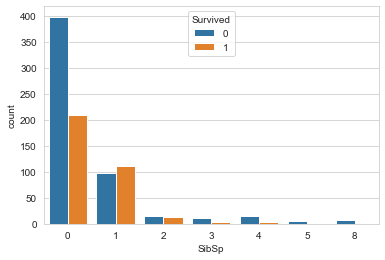

In [7]:
sns.countplot(x='SibSp', hue='Survived', data=train_df);

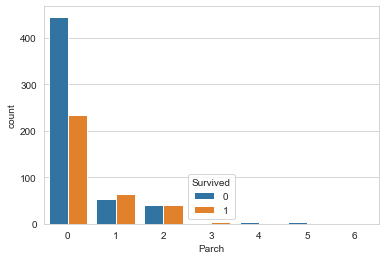

In [8]:
sns.countplot(x='Parch', hue='Survived', data=train_df);

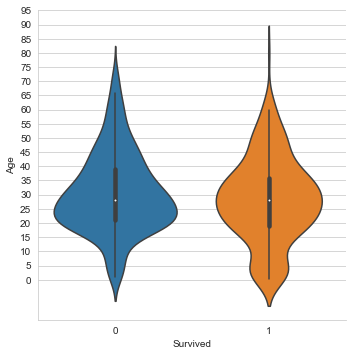

In [9]:
a = sns.catplot(x='Survived', y='Age', kind='violin', split=True, data=train_df);
a.set(yticks=np.arange(0,100,5));

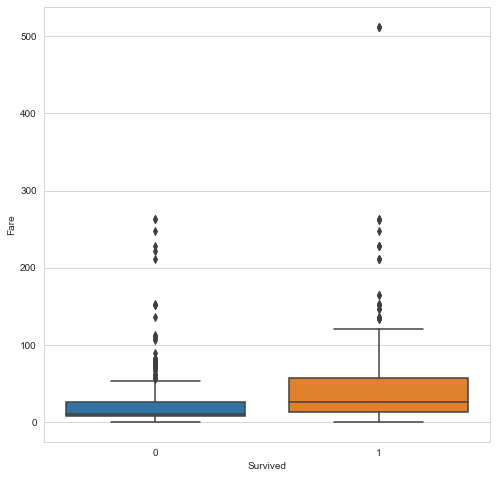

In [10]:
plt.figure(figsize=(8,8))
sns.boxplot(x='Survived', y='Fare', data=train_df);

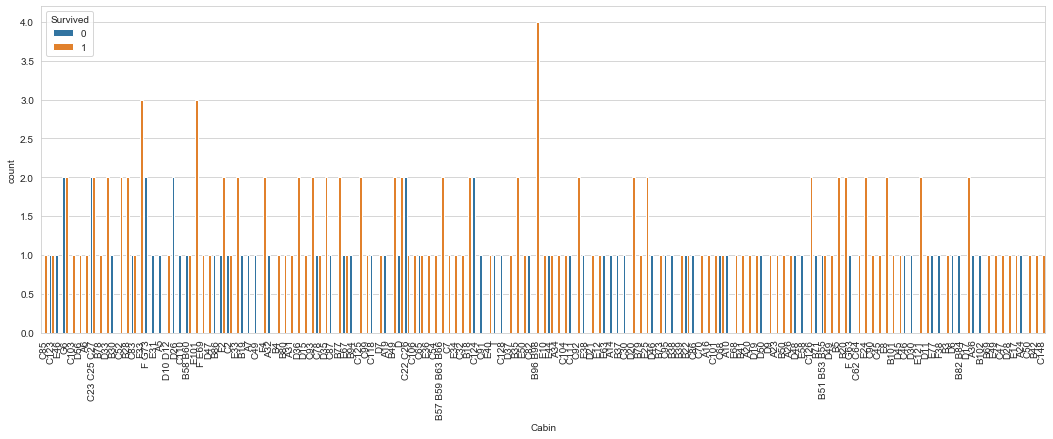

In [11]:
plt.figure(figsize=(18,6))
sns.countplot(x='Cabin', hue='Survived', data=train_df)
plt.xticks(rotation=90);


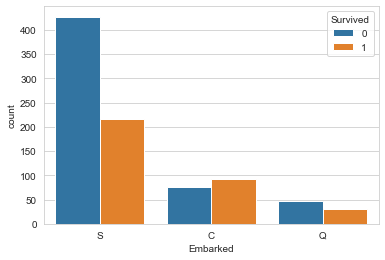

In [12]:
sns.countplot(x='Embarked', hue='Survived', data=train_df);

**Feature engineering and preparing dataset**

In [13]:
# extract Target
train_y = train_df.pop('Survived')
# concatenate train and test
train_split = train_df.shape[0]
full_df = pd.concat((train_df, test_df))
full_df = full_df.reset_index(drop=True)

In [14]:
# take a look at missing values
full_df.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [15]:
# filling NaN's most common values
full_df['Age'].fillna(full_df['Age'].mean(), inplace = True)
full_df['Fare'] = full_df.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))
full_df['Cabin'].fillna('N', inplace = True)
full_df['Embarked'].fillna('S', inplace = True)

In [16]:
# create new feature - Deck
full_df['Deck'] = full_df['Cabin'].str[0]

In [17]:
# create new feature - Number passengers in cabin
full_df['Num_in_cab'] = full_df.groupby('Cabin')['Cabin'].transform('count')
# for passangers w/o Cabin set their value equal zero
full_df['Num_in_cab'].replace(full_df['Num_in_cab'].max(), 0, inplace = True)

In [18]:
# split dataset back
train_df, test_df = full_df.iloc[:train_split], full_df.iloc[train_split:]
train_df.shape, train_y.shape, test_df.shape

((891, 13), (891,), (418, 13))

In [19]:
print(train_df.dtypes)
train_df.columns

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Deck            object
Num_in_cab       int64
dtype: object


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Deck', 'Num_in_cab'],
      dtype='object')

In [20]:
# select categorial features for model
cat_feat = ['PassengerId', 'Pclass', 'Name', 'Sex',  'SibSp', 'Parch',
            'Ticket','Cabin', 'Embarked', 'Deck', 'Num_in_cab']
print(cat_feat)

['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Deck', 'Num_in_cab']


## Applying model

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(train_df, train_y, train_size = 0.75, random_state = 35, stratify = train_y)

In [22]:
model1 = CatBoostClassifier(
    iterations= 1000,
    task_type="GPU",
    random_seed=35,
    learning_rate=0.01,
    loss_function='Logloss',
    use_best_model=True,
    custom_loss=['Accuracy'],
    od_type='Iter',
    od_wait=20
)
model1.fit(
    X_train, y_train,
    cat_features=cat_feat,
    eval_set=(X_validation,
              y_validation),
    logging_level='Silent',
    plot = False
)

In [23]:
params = model1.get_params()
del params['use_best_model']

In [24]:
pool1 = Pool(train_df, train_y, cat_features = cat_feat)
cv_data = cv(
    params=params,
    pool=pool1,
    fold_count=3,     
    partition_random_seed=35,     
    stratified=True,
    verbose=False,
    plot=False)

In [25]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Accuracy-mean'].max()
    best_iter = cv_data['test-Accuracy-mean'].values.argmax()

    print('Best validation Accuracy score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Accuracy-std'][best_iter],
        best_iter)
    )

print_cv_summary(cv_data)

Best validation Accuracy score : 0.8272±0.0282 on step 1


In [27]:
model1 = CatBoostClassifier(
    iterations = 187,
    task_type="GPU",
    random_seed = 35,
    learning_rate = 0.01,
    loss_function = 'Logloss',
#    use_best_model = True,
    custom_loss = ['Accuracy'],
    od_type='Iter',
    od_wait=20
)
model1.fit(
    X_train, y_train,
    cat_features = cat_feat,
    logging_level = 'Silent'
)

In [28]:
submisstion = pd.DataFrame()
submisstion['PassengerId'] = test_df['PassengerId']
submisstion['Survived'] = model1.predict(test_df)
submisstion.to_csv('submission.csv', index=False)
# Public liderboard score 0.79904

## Feature importance

In [29]:
feature_importance_df = pd.DataFrame(model1.get_feature_importance(prettified=True))
feature_importance_df

,Feature Id,Importances
0,Sex,62.410852
1,Pclass,13.891574
2,Age,5.626923
3,Ticket,4.851502
4,Fare,4.845576
5,Num_in_cab,2.168464
6,Embarked,1.816301
7,Deck,1.362362
8,Parch,1.185506
9,Cabin,1.039348


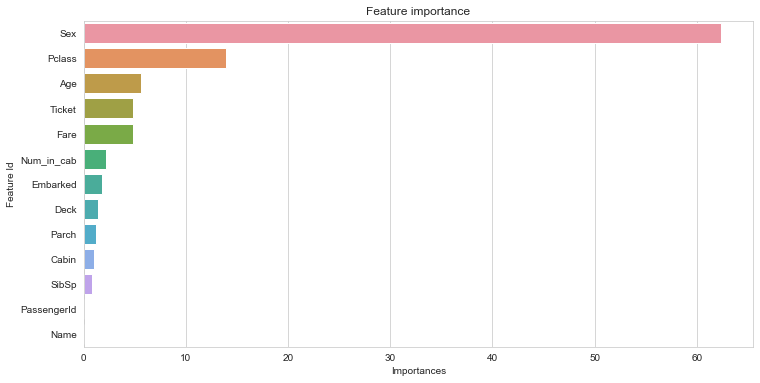

In [30]:
plt.figure(figsize=(12, 6));
sns.barplot(x = 'Importances', y = 'Feature Id', data = feature_importance_df);
plt.title('Feature importance');

In [31]:
import shap
shap_values = model1.get_feature_importance(pool1, type='ShapValues')

In [32]:
expected_value = shap_values[0, -1]

In [33]:
shap_values = shap_values[:,:-1]

In [34]:
shap.initjs()
shap.force_plot(expected_value, shap_values[30,:], train_df.iloc[30,:])

In [35]:
shap.force_plot(expected_value, shap_values[:100], train_df.iloc[0:100])

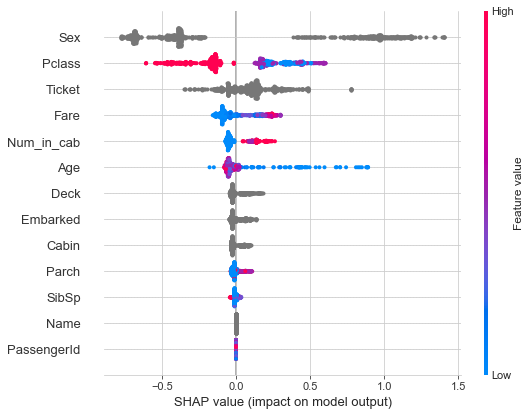

In [36]:
shap.summary_plot(shap_values, train_df)